In [1]:
import yaml
from lib.model import GMMModel
from lib.agent import AgentCollection, GMMAgent
from lib.social_media import SimpleMessageBoard

In this demo I want to scale up the original ideas presented in the wolf forest to a larger sim with 1,000 agents who are each observing part of an environment with dozens of different animal dens. 

Here we will have wolves, foxes, fairies, and more!

<ipython-input-2-122ead43b521>:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(open("cfg/magic_forest.yaml"))


torch.Size([1, 12, 2]) torch.Size([1, 12, 2]) torch.Size([1, 12, 1])


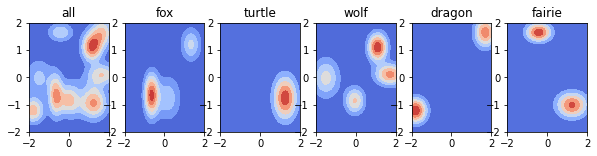

torch.Size([1, 12, 2]) torch.Size([1, 12, 2]) torch.Size([1, 12, 1])


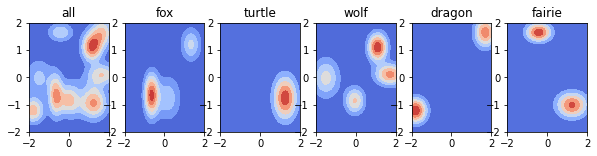

In [2]:

cfg = yaml.load(open("cfg/magic_forest.yaml"))

magic_forest = GMMModel(cfg["environment"])
magic_forest.render_all()

torch.Size([1, 12, 2]) torch.Size([1, 12, 2]) torch.Size([1, 12, 1])


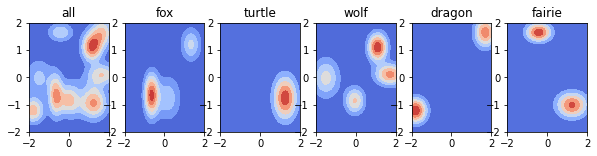

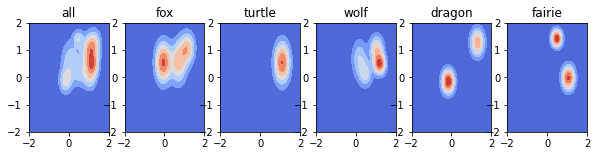

In [7]:
def multiply_gaussians(mean, var, row):
    mean_x1, mean_y1 = mean
    var_x1, var_y1 = var

    mean_x2, mean_y2 = row["mean_x"], row["mean_y"]
    var_x2, var_y2 = row["var_x"], row["var_y"]

    mean_x3 = (var_x1 * mean_x2 + var_x2 * mean_x1) / (var_x1 + var_x2)
    mean_y3 = (var_y1 * mean_y2 + var_y2 * mean_y1) / (var_y1 + var_y2)

    var_x3 = 1 / ((1 / var_x1) + (1 / var_x2))
    var_y3 = 1 / ((1 / var_y1) + (1 / var_y2))

    row_out = row.copy()
    row_out["mean_x"] = mean_x3
    row_out["mean_y"] = mean_y3
    row_out["var_x"] = var_x3
    row_out["var_x"] = var_y3
    return row_out

def partial_observe(mean, var, magic_forest):
    return magic_forest.df.apply(
        lambda row: multiply_gaussians(mean, var, row), axis=1
    )

partial_df = partial_observe((1, 1), (0.1, 0.1), magic_forest)

new_gmm = GMMModel.from_df(partial_df)
magic_forest.render_all()
new_gmm.render_all()

In [27]:
import torch
mf_df = magic_forest.df



tensor([[[-0.0834,  1.1808],
         [-0.1924,  1.3647],
         [-0.9655, -0.7081],
         [-1.7995, -1.9539],
         [ 1.1324,  0.7333],
         [ 1.1741, -0.8656],
         [ 1.1260,  1.2738],
         [ 0.8027,  0.8595],
         [-1.8336, -0.6455],
         [ 0.6976,  0.4976],
         [-1.0746, -1.3197],
         [ 0.9909,  1.7633]]])


tensor([[[0.0469, 0.0705, 0.0918, 0.1131, 0.0975, 0.0719, 0.0445, 0.0652,
          0.1132, 0.1033, 0.0795, 0.1025]]])

Here each agent only has partial observability, meaning they can only view a circle with a radius of 1 around them. 

Each agent starts in a different spot, so together they can see everything, but on their own they can never learn the entire map

In [ ]:
from lib.utils import in_range
samples = magic_forest.sample(10000)

view_fn = lambda explorer, samples: samples.apply(
                lambda col: in_range(explorer.location, [col["x"], col["y"]], self.view_radius),
                axis=1,
            )


direct_evidence = explorers.map(view_fn, samples)
explorers.train(samples)

explorers.render()

With no misinformation, a simple messageboard for sharing samples, and full trust in each-other they should be able to learn the locations of all the animal dens

In [ ]:
messageboard = SimpleMessageBoard()


However, as soon as we add misinformation, we start to see the same problems arise. Lets add in our fox from last time, he just falsely reports wolf sightings around fox dens. We'll deal with more sophisticated liars later. 

In [ ]:
fox = SimpleDeceiver(reports="Wolves", area=cfg["environment"]["fox"])

Dang fox. Well, obviously they believed it, *these* explorers believe *everything*. 

Hmm, lets use our trust based strategy from before, where agents train a model on their direct observations and then discard any posts that seem too unlikely by that model. However, in this case consider the fact that agents can only directly observe things in their bubble... this probably won't work but lets see what happens. 

In [ ]:
def trust_strategy(agent, data):
    

Ah, nobody trusts each other! We end up with a situation almost identical to the no-sharing situation! Now we're in a bit of a pickle. 

Maybe sit for a minute and think about potential solutions, and how you might model them...

Here's one I just came up with (on August 18th 2022): People in real life tend to have a social circle around them that they trust, probably because they have a lot of similar shared experiences. Like I trust my coworkers when it comes to work stuff, because I can see that they have been right in the past, and I could verify if they lied to me. Maybe we can use the same trust test, but only look at regions where the agents experience bubbles overlap? 

Ok good, that got our circle a bit bigger! But we've only expanded our bubble by the radius of one extra circle. 

To get us a bit further, maybe we trust friends of friends? And their friends too?

So as soon as you trust one person, you also trust their friends and distrust the people they distrust, and then do this repeatedly. Each link in the chain should get us one ring further out!

I haven't seen this idea before, but I had it in a vision one night and called it the truth graph, which is why this repo is named this way. Drugs may have been involved.

It's the way I think an ideal social media should work. This kind of a structure makes it hard for liars, bullshitters, and all other types of epistemic miscreants to get big - but it does rely on some assumptions and it does need some hardening, which I will go more into later. 

Obviously though this truth graph is not how we do things now. I've never gone to a friend and asked them to get me a kevin bacon tree 8 nodes out of people I can trust.

What we do right now is mostly view social media. At least that's what I do, I'm a reddit addict and have been for like 13 years? Since highschool.

The samples that I see are the samples that reddit shows me. Reddit is a complicated beast, but maybe we can simulate something kinda-like reddit? Or facebook? Or 4chan?

Tune in next time